In [1]:
# 禁用 dtensor 模块以防止加载问题
import os
os.environ["TF_DTENSOR_ENABLED"] = "0"

# 导入 TensorFlow 和 Keras 模块
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 其他可能需要的包
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

print("Is GPU available:", tf.config.list_physical_devices('GPU'))


Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 基础CNN调参

In [8]:
# 数据路径设置
data_dir = "data"
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# 图像数据增强
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对所有像素值进行归一化
)

validation_datagen = ImageDataGenerator(
    rescale=1./255  # 对验证集归一化，但不进行其他数据增强
)

# 训练数据生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # 调整图像大小
    batch_size=32,  # 每批次加载的图像数
    class_mode='binary'  # 二分类模式
)

# 验证数据生成器
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),  # 调整图像大小
    batch_size=32,  # 每批次加载的图像数
    class_mode='binary'  # 二分类模式
)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [ ]:
def create_model(optimizer=None, learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # 二分类
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# 网格搜索参数
learning_rates = [0.001]
optimizers = ['adam']
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 保存结果
results = []

for optimizer in optimizers:
    for lr in learning_rates:
        print(f"Training with optimizer={optimizer}, learning_rate={lr}")
        fold_acc = []
        
        #for train_index, val_index in kf.split(train_generator):
        model = create_model(optimizer=optimizer, learning_rate=lr)
        with tf.device('/GPU:0'):
        # 训练模型
            history = model.fit(
                train_generator,
                epochs=10,
                validation_data=validation_generator,
                verbose=1
            )
        
        # 记录验证准确率
        val_acc = history.history['val_accuracy'][-1]
        fold_acc.append(val_acc)
        
        avg_acc = np.mean(fold_acc)
        results.append((optimizer, lr, avg_acc))
        print(f"Optimizer: {optimizer}, Learning Rate: {lr}, Average Validation Accuracy: {avg_acc:.4f}")

# 打印结果
best_result = max(results, key=lambda x: x[2])
print("\nBest Hyperparameters:")
print(f"Optimizer: {best_result[0]}, Learning Rate: {best_result[1]}, Validation Accuracy: {best_result[2]:.4f}")


Training with optimizer=adam, learning_rate=0.001
Epoch 1/10
 47/586 [=>............................] - ETA: 19s - loss: 0.6910 - accuracy: 0.5352

KeyboardInterrupt: 

### VGG16模型，训练效果很好

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义 VGG16 模型
class VGG16(tf.keras.Model):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.features = models.Sequential([
            layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),
        ])
        self.classifier = models.Sequential([
            layers.Flatten(),
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax'),
        ])

    def call(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 使用 ImageDataGenerator 加载并预处理数据集
data_dir = 'data'
input_shape = (224, 224)
batch_size = 4

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory(
    directory=f'{data_dir}/train',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    directory=f'{data_dir}/validation',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary'
)

# 初始化模型、优化器和损失函数
model = VGG16(num_classes=2)
# 构建模型结构（明确指定输入形状）
model.build(input_shape=(None, 224, 224, 3))  # None 表示动态批次大小

# 查看模型结构
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 训练循环
epochs = 20
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

for epoch in range(epochs):
    print(f"=========== Epoch {epoch + 1} ==============")
    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_gen,
                        validation_steps=validation_steps,
                        epochs=1)
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    val_accuracy = history.history['val_accuracy'][0]
    print(f"训练集上的损失：{train_loss}")
    print(f"验证集上的损失：{val_loss}")
    print(f"验证集上的精度：{val_accuracy:.1%}")
    
    # 保存模型
    model.save_weights(f"Adogandcat_epoch_{epoch + 1}.h5")
    print("模型已保存。")



Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Model: "vg_g16_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_35 (Sequential)   (None, 7, 7, 512)         9220480   
_________________________________________________________________
sequential_36 (Sequential)   (None, 2)                 119554050 
Total params: 128,774,530
Trainable params: 128,774,530
Non-trainable params: 0
_________________________________________________________________
=========== Epoch 1 ==============
  57/4687 [..............................] - ETA: 2:06 - loss: 0.7009 - accuracy: 0.4474

KeyboardInterrupt: 

### 使用VGG16作为预模型训练CNN，效果和原VGG16差不多

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义 VGG16 模型
class VGG16(tf.keras.Model):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.features = models.Sequential([
            layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),

            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), strides=(2, 2)),
        ])
        self.classifier = models.Sequential([
            layers.Flatten(),
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax'),
        ])

    def call(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 使用 ImageDataGenerator 加载并预处理数据集
data_dir = 'data'
input_shape = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory(
    directory=f'{data_dir}/train',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    directory=f'{data_dir}/validation',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary'
)

# 加载预训练的 VGG16 模型权重
vgg16_base = VGG16(num_classes=2)
vgg16_base(np.zeros((1, 224, 224, 3)))  # 先调用模型创建变量
vgg16_base.load_weights('Adogandcat_epoch_20.h5')  # 假设已经训练并保存了第 20 轮的模型权重

# 冻结 VGG16 的卷积层，只训练分类器部分
for layer in vgg16_base.features.layers:
    layer.trainable = False

# 定义新的 CNN 模型，并使用 VGG16 作为特征提取器
class CustomCNN(tf.keras.Model):
    def __init__(self, vgg16_base, num_classes=2):
        super(CustomCNN, self).__init__()
        self.vgg16_base = vgg16_base.features  # 使用 VGG16 的特征提取部分
        self.new_classifier = models.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax'),
        ])

    def call(self, x):
        x = self.vgg16_base(x)
        x = self.new_classifier(x)
        return x

# 初始化新的 CNN 模型、优化器和损失函数
model = CustomCNN(vgg16_base=vgg16_base, num_classes=2)

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 训练循环
epochs = 10
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

for epoch in range(epochs):
    print(f"=========== Epoch {epoch + 1} ==============")
    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_gen,
                        validation_steps=validation_steps,
                        epochs=1)
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    val_accuracy = history.history['val_accuracy'][0]
    print(f"训练集上的损失：{train_loss}")
    print(f"验证集上的损失：{val_loss}")
    print(f"验证集上的精度：{val_accuracy:.1%}")
    
    # 保存模型
    model.save_weights(f"CustomCNN_epoch_{epoch + 1}.h5")
    print("模型已保存。")


Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Model: "custom_cnn_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 7, 7, 512)         9220480   
_________________________________________________________________
sequential_34 (Sequential)   (None, 2)                 6423298   
Total params: 15,643,778
Trainable params: 6,423,298
Non-trainable params: 9,220,480
_________________________________________________________________
=========== Epoch 1 ==============
 21/585 [>.............................] - ETA: 2:02 - loss: 0.6707 - accuracy: 0.8527

KeyboardInterrupt: 

### 预测结果

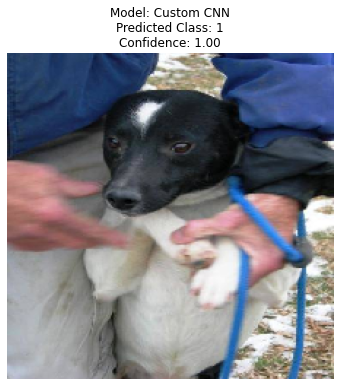

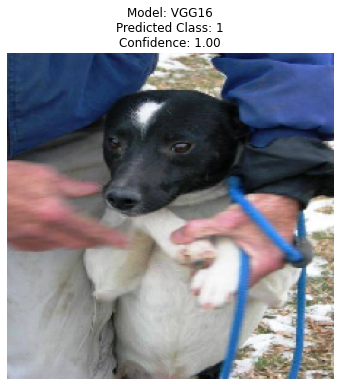

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# 加载训练好的 CustomCNN 模型
class CustomCNN(tf.keras.Model):
    def __init__(self, vgg16_base, num_classes=2):
        super(CustomCNN, self).__init__()
        self.vgg16_base = vgg16_base.features  # 使用 VGG16 的特征提取部分
        self.new_classifier = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax'),
        ])

    def call(self, x):
        x = self.vgg16_base(x)
        x = self.new_classifier(x)
        return x

# 定义和加载 CustomCNN
vgg16_base = VGG16(num_classes=2)  # 使用之前定义的 VGG16 类
vgg16_base.build(input_shape=(None, 224, 224, 3))  # 构建 VGG16 基础
vgg16_base.load_weights('Adogandcat_epoch_20.h5')  # 加载预训练的 VGG16 权重

custom_cnn = CustomCNN(vgg16_base=vgg16_base, num_classes=2)
custom_cnn.build(input_shape=(None, 224, 224, 3))
custom_cnn.load_weights('CustomCNN_epoch_10.h5')  # 替换为训练好的 CustomCNN 权重路径

# 定义和加载 VGG16 模型
vgg16 = VGG16(num_classes=2)
vgg16.build(input_shape=(None, 224, 224, 3))
vgg16.load_weights('Adogandcat_epoch_20.h5')  # 替换为训练好的 VGG16 权重路径

# 加载和预处理图像
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # 加载图像并调整大小
    img_array = img_to_array(img)  # 转换为 NumPy 数组
    img_array = np.expand_dims(img_array, axis=0)  # 添加批次维度
    img_array = preprocess_input(img_array)  # VGG16 所需的标准化
    return img, img_array

# 预测和显示图像
def predict_and_display(image_path, model, model_name):
    # 加载图像
    original_img, processed_img = load_and_preprocess_image(image_path)

    # 预测类别
    predictions = model(processed_img, training=False)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]

    # 显示结果
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Model: {model_name}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

# 测试图像路径
image_path = 'data/test/1.jpg'  # 替换为实际图像路径

# 使用 CustomCNN 预测
predict_and_display(image_path, custom_cnn, "Custom CNN")

# 使用 VGG16 预测
predict_and_display(image_path, vgg16, "VGG16")
